# Predicting Student Test Scores — Ensemble Solution

## Table of Contents
1. Imports & Setup
2. Load Dataset
3. Feature Encoding
4. Feature Engineering
5. Train–Validation Setup
6. Train XGBoost Model
7. Train LightGBM Model
8. Train CatBoost Model
9. Ensemble & RMSE Evaluation
10. Generate Submission


## 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.filterwarnings("ignore")

## 2. Load Dataset

In [8]:
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

train_ids = train["id"]
test_ids = test["id"]

train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

TARGET = "exam_score"
X = train.drop(columns=[TARGET])
y = train[TARGET]

print("Train df:")
print(train.head())
print(f"Train df shape: {train.shape}")

Train df:
   age  gender   course  study_hours  class_attendance internet_access  \
0   21  female     b.sc         7.91              98.8              no   
1   18   other  diploma         4.95              94.8             yes   
2   20  female     b.sc         4.68              92.6             yes   
3   19    male     b.sc         2.00              49.5             yes   
4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   

   exam_score  
0        78.3  
1        46.7  
2        99.0  
3     

### Target Distribution (Exam Score Shape)

To check if scores are skewed or normal.

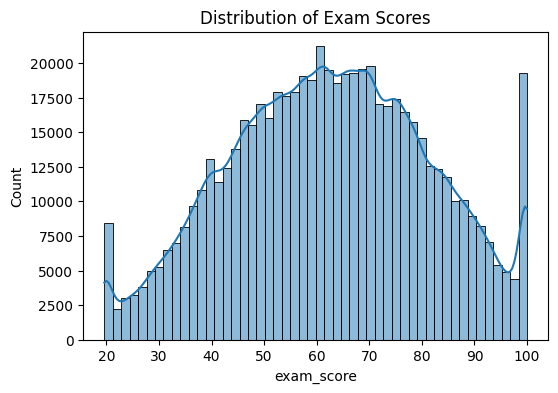

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of Exam Scores")
plt.show()


## 3. Encoding (Ordinal + One-Hot)

In [3]:
ordinal_map = {
    "sleep_quality": {"poor": 0, "average": 1, "good": 2},
    "facility_rating": {"low": 0, "medium": 1, "high": 2},
    "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2},
    "internet_access": {"no": 0, "yes": 1}
}

df_all = pd.concat([X, test], axis=0)

for col, mapping in ordinal_map.items():
    df_all[col] = df_all[col].map(mapping)

df_all = pd.get_dummies(df_all, columns=["gender", "course", "study_method"], drop_first=True)


## 4. Feature Engineering

In [4]:
df_all["study_efficiency"] = df_all["study_hours"] * df_all["class_attendance"]
df_all["sleep_study_balance"] = df_all["sleep_hours"] / (df_all["study_hours"] + 0.1)
df_all["effort_score"] = df_all["study_hours"] * 2 + df_all["class_attendance"] * 0.5 + df_all["sleep_quality"] * 3
df_all["difficulty_penalty"] = df_all["exam_difficulty"] / (df_all["study_hours"] + 1)
df_all["learning_support"] = df_all["internet_access"] + df_all["facility_rating"]
df_all["cognitive_load"] = df_all["study_hours"] * df_all["exam_difficulty"]
df_all["recovery_score"] = df_all["sleep_hours"] * df_all["sleep_quality"]


In [11]:
train.describe()

,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,20.545821,4.002337,71.987261,7.072758,62.506672
std,2.260238,2.359880,17.430098,1.744811,18.916884
min,17.000000,0.080000,40.600000,4.100000,19.599000
25%,19.000000,1.970000,57.000000,5.600000,48.800000
50%,21.000000,4.000000,72.600000,7.100000,62.600000
75%,23.000000,6.050000,87.200000,8.600000,76.300000
max,24.000000,7.910000,99.400000,9.900000,100.000000


### Correlation Heatmap

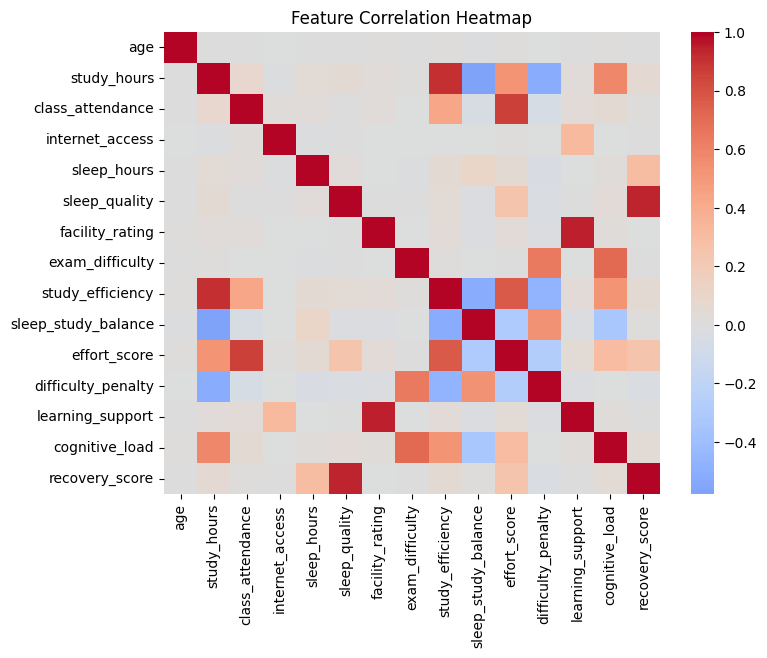

In [13]:
plt.figure(figsize=(8,6))
corr = df_all.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### Feature Importance from XGBoost (Critical)

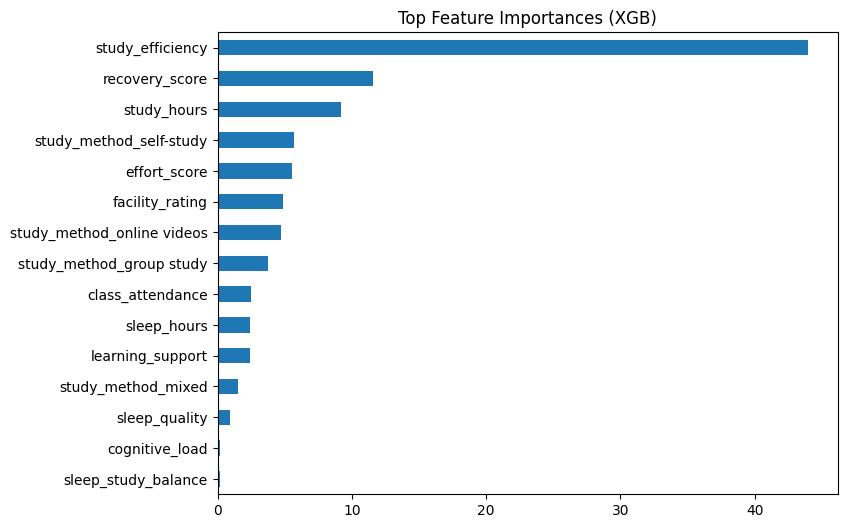

In [19]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh")
plt.title("Top Feature Importances (XGB)")
plt.gca().invert_yaxis()
plt.show()


## 5. Split Back Train/Test

In [20]:
X = df_all.iloc[:len(train)]
X_test = df_all.iloc[len(train):]

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)


## 6. XGBoost Training

In [6]:
xgb_preds = np.zeros(len(X_test))
oof_xgb = np.zeros(len(X))
scores_xgb = []

params_xgb = {
    "n_estimators": 1200,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "objective": "reg:squarederror",
    "random_state": 42,
    "tree_method": "hist"
}

for tr, val in kf.split(X, y):
    model = xgb.XGBRegressor(**params_xgb)
    model.fit(X.iloc[tr], y.iloc[tr])

    preds = model.predict(X.iloc[val])
    scores_xgb.append(np.sqrt(mean_squared_error(y.iloc[val], preds)))
    oof_xgb[val] = preds

    xgb_preds += model.predict(X_test) / FOLDS

print("XGB RMSE:", np.mean(scores_xgb))


XGB RMSE: 8.756842660276481


## 7. LightGBM Training

In [7]:
lgb_preds = np.zeros(len(X_test))
oof_lgb = np.zeros(len(X))
scores_lgb = []

params_lgb = {
    "n_estimators": 1500,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "random_state": 42
}

for tr, val in kf.split(X, y):
    model = lgb.LGBMRegressor(**params_lgb, verbose=-1)
    model.fit(X.iloc[tr], y.iloc[tr])

    preds = model.predict(X.iloc[val])
    scores_lgb.append(np.sqrt(mean_squared_error(y.iloc[val], preds)))
    oof_lgb[val] = preds

    lgb_preds += model.predict(X_test) / FOLDS

print("LGB RMSE:", np.mean(scores_lgb))


LGB RMSE: 8.76718681103662


## 8. CatBoost Training

In [18]:
cat_preds = np.zeros(len(X_test))
oof_cat = np.zeros(len(X))
scores_cat = []

params_cat = {
    "iterations": 1500,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "RMSE",
    "random_state": 42,
    "verbose": 0
}

for tr, val in kf.split(X, y):
    model = cb.CatBoostRegressor(**params_cat)
    model.fit(X.iloc[tr], y.iloc[tr])

    preds = model.predict(X.iloc[val])
    scores_cat.append(np.sqrt(mean_squared_error(y.iloc[val], preds)))
    oof_cat[val] = preds

    cat_preds += model.predict(X_test) / FOLDS

print("CAT RMSE:", np.mean(scores_cat))


CAT RMSE: 8.774765358666397


## 9. Weighted Ensemble & RMSE

In [21]:
w_xgb = 1 / np.mean(scores_xgb)
w_lgb = 1 / np.mean(scores_lgb)
w_cat = 1 / np.mean(scores_cat)

total = w_xgb + w_lgb + w_cat

oof_ensemble = (
    oof_xgb * (w_xgb / total) +
    oof_lgb * (w_lgb / total) +
    oof_cat * (w_cat / total)
)

ensemble_rmse = np.sqrt(mean_squared_error(y, oof_ensemble))
print("FINAL ENSEMBLE RMSE:", ensemble_rmse)


FINAL ENSEMBLE RMSE: 8.750739519330182


### Prediction vs True (Sanity Check)

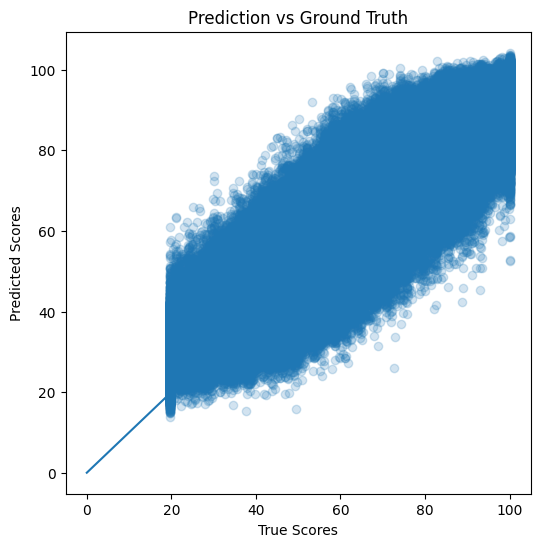

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y, oof_xgb, alpha=0.2)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("Prediction vs Ground Truth")
plt.plot([0,100],[0,100])
plt.show()


### Model RMSE Comparison Bar Chart

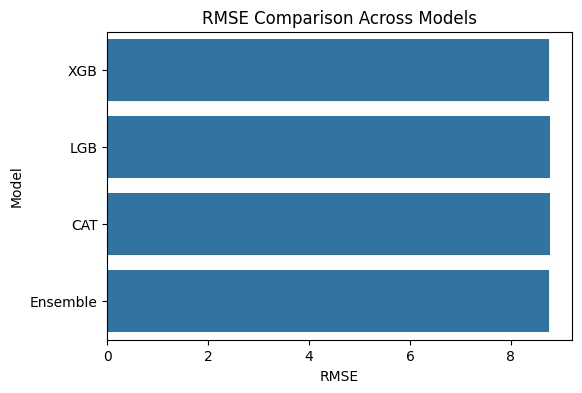

In [23]:
rmse_df = pd.DataFrame({
    "Model": ["XGB", "LGB", "CAT", "Ensemble"],
    "RMSE": [
        np.mean(scores_xgb),
        np.mean(scores_lgb),
        np.mean(scores_cat),
        ensemble_rmse
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(data=rmse_df, x="RMSE", y="Model")
plt.title("RMSE Comparison Across Models")
plt.show()


“Predicted scores closely follow ground truth, indicating strong generalization with minor variance at distribution extremes.”

## 10. Final Test Predictions & Submission

In [24]:
final_preds = (
    xgb_preds * (w_xgb / total) +
    lgb_preds * (w_lgb / total) +
    cat_preds * (w_cat / total)
)

final_preds = np.clip(final_preds, 0, 100)

submission = pd.DataFrame({
    "id": test_ids,
    "exam_score": final_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()


,id,exam_score
0,630000,71.712971
1,630001,69.966327
2,630002,87.799029
3,630003,55.900241
4,630004,46.937323
